In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 3.4 MB/s eta 0:00:00


In [3]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from deap import base, creator, tools, algorithms
import random

In [4]:
df_price = pd.read_excel("/content/drive/MyDrive/ts_data/AAPL_price_2010_2025.xlsx")
df_earnings = pd.read_excel("/content/drive/MyDrive/ts_data/10to25_AAPL_Earning_Data.xlsx")

In [5]:
print(df_price.shape)
print(df_earnings.shape)

(3774, 8)
(66, 4)


In [6]:
df_price.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-01-04,6.422877,6.455077,6.391278,6.440331,493729600,0.0,0
1,2010-01-05,6.458085,6.487878,6.417459,6.451465,601904800,0.0,0
2,2010-01-06,6.451467,6.477047,6.342228,6.348848,552160000,0.0,0
3,2010-01-07,6.372319,6.379843,6.291067,6.337110,477131200,0.0,0
4,2010-01-08,6.328683,6.379843,6.291368,6.379241,447610800,0.0,0


In [7]:
df_earnings.head()

,Earnings Date,EPS Estimate,Reported EPS,Surprise(%)
0,2026-04-29 06:59:00,NaN,NaN,NaN
1,2026-01-28 16:00:00,NaN,NaN,NaN
2,2025-10-29 06:59:00,NaN,NaN,NaN
3,2025-07-30 06:59:00,NaN,NaN,NaN
4,2025-05-01 16:30:00,1.63,1.65,1.41


In [8]:
df_price.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0
Dividends,0
Stock Splits,0


In [9]:
df_earnings.isnull().sum()

,0
Earnings Date,0
EPS Estimate,4
Reported EPS,4
Surprise(%),4


실적 데이터 결측치 제거

In [10]:
df_earnings.dropna(inplace=True)
print(df_earnings.shape)

(62, 4)


In [11]:
df_earnings.isnull().sum()

,0
Earnings Date,0
EPS Estimate,0
Reported EPS,0
Surprise(%),0


In [12]:
df_price.describe()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,3774,3774.000000,3774.000000,3774.000000,3774.000000,3.774000e+03,3774.000000,3774.000000
mean,2017-07-01 21:42:38.346582016,67.465510,68.176227,66.797248,67.521690,2.299200e+08,0.002316,0.002915
min,2010-01-04 00:00:00,5.789106,5.898343,5.725307,5.779475,2.323470e+07,0.000000,0.000000
25%,2013-10-02 06:00:00,17.465273,17.645444,17.316007,17.461678,8.492275e+07,0.000000,0.000000
50%,2017-07-01 12:00:00,35.354724,35.728738,34.963333,35.323723,1.403920e+08,0.000000,0.000000
75%,2021-03-31 18:00:00,126.339091,127.999175,124.827832,126.909618,3.081386e+08,0.000000,0.000000
max,2024-12-31 00:00:00,257.906429,259.814335,257.347047,258.735504,1.880998e+09,0.250000,7.000000
std,NaN,65.523836,66.212381,64.904100,65.602673,2.180726e+08,0.020785,0.131222


In [13]:
df_earnings.describe()

,Earnings Date,EPS Estimate,Reported EPS,Surprise(%)
count,62,62.000000,62.000000,62.000000
mean,2017-09-11 17:14:38.709677568,0.765000,0.818065,9.280323
min,2010-01-25 00:00:00,0.070000,0.120000,-10.120000
25%,2013-11-19 18:00:00,0.360000,0.375000,2.132500
50%,2017-09-17 04:30:00,0.545000,0.605000,4.255000
75%,2021-07-05 04:30:00,1.155000,1.257500,12.302500
max,2025-05-01 16:30:00,2.350000,2.400000,76.000000
std,NaN,0.548461,0.571414,13.586390


In [14]:
# 신호 생성 함수

def create_MA_GDC(df, short_w, long_w):
    df["MA_short"] = df["Close"].rolling(window=short_w).mean()
    df["MA_long"] = df["Close"].rolling(window=long_w).mean()

    df['MA_GDC'] = 0
    MA_cross_up = (df['MA_short'] > df['MA_long']) & (df['MA_short'].shift(1) <= df['MA_long'].shift(1))
    MA_cross_down = (df['MA_short'] < df['MA_long']) & (df['MA_short'].shift(1) >= df['MA_long'].shift(1))
    df.loc[MA_cross_up, 'MA_GDC'] = 1  # Golden Cross
    df.loc[MA_cross_down, 'MA_GDC'] = -1  # Dead Cross


def create_SO_GDC(df, w):
    df['Low_w'] = df['Low'].rolling(window=w).min()
    df['High_w'] = df['High'].rolling(window=w).max()
    df['%K'] = (df['Close'] - df['Low_w']) / (df['High_w'] - df['Low_w']) * 100
    df['%D'] = df['%K'].rolling(window=3).mean()

    df['SO_GDC'] = 0
    SO_cross_up = (df['%K'] > df['%D']) & (df['%K'].shift(1) <= df['%D'].shift(1))
    SO_cross_down = (df['%K'] < df['%D']) & (df['%K'].shift(1) >= df['%D'].shift(1))
    df.loc[SO_cross_up, 'SO_GDC'] = 1  # Golden Cross
    df.loc[SO_cross_down, 'SO_GDC'] = -1  # Dead Cross

def create_SO_momentum(df, w):
    df['Low_w'] = df['Low'].rolling(window=w).min()
    df['High_w'] = df['High'].rolling(window=w).max()
    df['%K'] = (df['Close'] - df['Low_w']) / (df['High_w'] - df['Low_w']) * 100
    df['%D'] = df['%K'].rolling(window=3).mean()

    SO_overbought = (df['%K'] > 80) & (df['%D'] > 80)
    SO_oversold = (df['%K'] < 20) & (df['%D'] < 20)
    df['SO_momentum'] = 0
    df.loc[SO_overbought, 'SO_momentum'] = -1
    df.loc[SO_oversold, 'SO_momentum'] = 1


def create_MACD_GDC(df, short_w, long_w, signal_w):
    df['EMA_short'] = df['Close'].ewm(span=short_w, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_w, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Signal'] = df['MACD'].ewm(span=signal_w, adjust=False).mean()

    MACD_cross_up = (df['MACD'] > df['Signal']) & (df['MACD'].shift(1) <= df['Signal'].shift(1))
    MACD_cross_down = (df['MACD'] < df['Signal']) & (df['MACD'].shift(1) >= df['Signal'].shift(1))
    df['MACD_GDC'] = 0
    df.loc[MACD_cross_up, 'MACD_GDC'] = 1
    df.loc[MACD_cross_down, 'MACD_GDC'] = -1


def create_BB_momentum(df, MA_w):
    df['MA_for_BB'] = df['Close'].rolling(window=MA_w).mean()
    df['BB_upper'] = df['MA_for_BB'] + 2 * df['Close'].rolling(window=MA_w).std()
    df['BB_lower'] = df['MA_for_BB'] - 2 * df['Close'].rolling(window=MA_w).std()

    BB_overbought = df['Close'] > df['BB_upper']
    BB_oversold = df['Close'] < df['BB_lower']
    df['BB_momentum'] = 0
    df.loc[BB_overbought, 'BB_momentum'] = -1
    df.loc[BB_oversold, 'BB_momentum'] = 1


def create_rsi_momentum(df, period=14):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    df['RSI_value'] = (100 - (100 / (1 + rs)))

    RSI_overbought = df['RSI_value'] > 80
    RSI_oversold = df['RSI_value'] < 20
    df['RSI_momentum'] = 0
    df.loc[RSI_overbought, 'RSI_momentum'] = -1
    df.loc[RSI_oversold, 'RSI_momentum'] = 1


def create_roc_GDC(df, period=10):
    df['ROC'] = ((df['Close'] - df['Close'].shift(period)) / df['Close'].shift(period) * 100)

    ROC_buy_signal = (df['ROC'].shift(1) < 0) & (df['ROC'] > 0)
    ROC_sell_signal = (df['ROC'].shift(1) > 0) & (df['ROC'] < 0)
    df['ROC_GDC'] = 0
    df.loc[ROC_buy_signal, 'ROC_GDC'] = 1
    df.loc[ROC_sell_signal, 'ROC_GDC'] = -1

def create_roc_momentum(df, period=10):
    df['ROC'] = ((df['Close'] - df['Close'].shift(period)) / df['Close'].shift(period) * 100)

    ROC_overbought = df['ROC'] > 10
    ROC_oversold = df['ROC'] < -10
    df['ROC_momentum'] = 0
    df.loc[ROC_overbought, 'ROC_momentum'] = -1
    df.loc[ROC_oversold, 'ROC_momentum'] = 1

In [15]:
#3일 뒤를 주식 가격으로 sell, hold, buy target 만들기
def make_target(rate):
    if rate > 1:
        return 1   # 상승 - 사라
    elif rate < -1:
        return -1  # 하락 - 팔아라
    else:
        return 0   # 유지 - 가만히 있어라

df_price["target_return_3d"] = df_price["Close"].shift(-3)
df_price["target_return_3d"] = (df_price["target_return_3d"] - df_price["Close"]) / df_price["Close"] * 100

df_price["target"] = df_price["target_return_3d"].apply(make_target)

In [16]:
#비율 확인
df_price["target"].value_counts()

,count
target,
1,1527
0,1157
-1,1090


모델이 예측하는 값을 토대로 유전자 알고리즘을 통해 기술적 지표를 최적화하는 것은 너무 오래걸림, 따라서 모델의 값을 이용하기 보다 target 자체를 이용하여 최적화

In [17]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)  #리스트로 처리

In [21]:
def create_individual():     #기술적 지표 기간 individual
    rsi_period = random.randint(5, 30)
    roc_period_GDC = random.randint(5, 30)
    roc_period_momentum = random.randint(5, 30)

    ma_short = random.randint(3, 25)
    while True:
        ma_long = random.randint(10, 80)
        if ma_long > ma_short:
            break

    macd_short = random.randint(3, 30)
    while True:
        macd_long = random.randint(15, 80)
        if macd_long > macd_short:
            break

    macd_signal = random.randint(3, 25)
    so_period_GDC = random.randint(3, 40)
    so_period_momentum = random.randint(3, 40)
    bb_ma_period = random.randint(5, 50)

    return creator.Individual([
        rsi_period,                 #gene[0]
        roc_period_GDC,             #gene[1]
        roc_period_momentum,        #gene[2]
        ma_short,                   #gene[3]
        ma_long,                    #gene[4]
        macd_short,                 #gene[5]
        macd_long,                  #gene[6]
        macd_signal,                #gene[7]
        so_period_GDC,              #gene[8]
        so_period_momentum,         #gene[9]
        bb_ma_period,               #gene[10]
    ])

휴리스틱 함수: 누적수익률과 최대낙폭을 작게하도록

In [48]:
def cumulative_return_and_MDD(df, ta_sig):   #누적수익률, 최대낙폭 계산 함수
  strategy_return = df[ta_sig] * (df["target_return_3d"]/100)
  cum_return = (1 + strategy_return).cumprod()

  max_cum_return = cum_return.cummax()
  drawdown = ((cum_return - max_cum_return) / max_cum_return).min()

  if cum_return.iloc[-1]<=1.01:    #아무것도 안 사는 전략을 방지
    return 0.00001, drawdown

  return cum_return.iloc[-1], drawdown


def fitness_function(gene, df):
    df = df.copy()
    create_rsi_momentum(df, gene[0])
    create_roc_GDC(df, gene[1])
    create_roc_momentum(df, gene[2])
    create_MA_GDC(df, gene[3], gene[4])
    create_MACD_GDC(df, gene[5], gene[6], gene[7])
    create_SO_GDC(df, gene[8])
    create_SO_momentum(df, gene[9])
    create_BB_momentum(df, gene[10])

    df.dropna(inplace=True) #Nan 값 제거

    total_cum_ret=0
    total_MDD=0
    for ta in ['RSI_momentum', 'ROC_GDC', 'ROC_momentum', 'MA_GDC', 'MACD_GDC', 'SO_GDC', 'SO_momentum', 'BB_momentum']:
      cum_ret, MDD = cumulative_return_and_MDD(df, ta)
      total_cum_ret += cum_ret
      total_MDD += MDD
    score = (1 / total_cum_ret) + (0.05)*abs(total_MDD) #최대낙폭을 작아지도록 학습하니 주식을 사지않는 방향으로 학습해버림, 작은 영향을 가지도록 0.05을 곱함
    return (score,)

In [23]:
#커스텀 돌연변이 함수
def custom_mutate(gene, mutant_rate=0.2):
    if random.random() < mutant_rate:
        gene[0] = random.randint(5, 40)  # rsi_period

    if random.random() < mutant_rate:
        gene[1] = random.randint(5, 40)  # roc_GDC_period

    if random.random() < mutant_rate:
        gene[2] = random.randint(5, 40)  # roc_momentum_period

    if random.random() < mutant_rate:
        gene[3] = random.randint(3, 40)  # ma_short
        gene[4] = random.randint(gene[3] + 1, 80)  # ma_long

    if random.random() < mutant_rate:
        gene[5] = random.randint(3, 40)  # macd_short
        gene[6] = random.randint(gene[5] + 1, 80)  # macd_long

    if random.random() < mutant_rate:
        gene[7] = random.randint(5, 25)  # macd_signal

    if random.random() < mutant_rate:
        gene[8] = random.randint(5, 40)  # so_GDC_period

    if random.random() < mutant_rate:
        gene[9] = random.randint(5, 40)  # so_momentum_period

    if random.random() < mutant_rate:
        gene[10] = random.randint(5, 50)  # bb_ma_period

    return (gene,)

In [49]:
toolbox=base.Toolbox()

#학습 과정 확인용 통계
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

#최적화
toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness_function, df=df_price)
toolbox.register("mate", tools.cxTwoPoint)  # 교차
toolbox.register("mutate", custom_mutate, mutant_rate=0.25)
toolbox.register("select", tools.selTournament, tournsize=3) #toursize는 3개 뽑아서 그 중 가장 좋은거 다음 세대 전달

pop = toolbox.population(n=300)
final_pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.4, ngen=100, stats=stats, verbose=True)

best_gene = tools.selBest(final_pop, k=1)[0]
print("Best Parameters:", best_gene)

gen	nevals	avg    	std    	min     	max    
0  	300   	708.877	2889.98	0.299412	12500.3
1  	203   	125.44 	1243.71	0.263839	12500.2
2  	210   	0.37129	0.0844333	0.263839	1.1172 
3  	197   	42.0111	720.476  	0.263839	12500.2
4  	217   	0.327506	0.0704034	0.254102	0.946032
5  	200   	41.9774 	720.48   	0.252693	12500.2 
6  	202   	0.302252	0.0472568	0.252693	0.566987
7  	216   	0.30318 	0.0783289	0.251439	1.13919 
8  	195   	0.290836	0.0474856	0.244197	0.649223
9  	217   	0.28492 	0.0493833	0.244197	0.658458
10 	197   	0.281222	0.0533985	0.241936	0.975498
11 	213   	0.279954	0.0595233	0.239314	0.861757
12 	211   	0.270568	0.0370723	0.239314	0.542602
13 	212   	0.273426	0.0487889	0.23676 	0.666235
14 	211   	0.269192	0.0422224	0.236035	0.483956
15 	214   	0.263603	0.0375518	0.236035	0.584124
16 	216   	0.257548	0.0318574	0.229829	0.453574
17 	209   	0.255808	0.0385832	0.229829	0.510057
18 	202   	0.257801	0.0406843	0.229829	0.492865
19 	221   	0.257372	0.0367142	0.229829	0.513894
20 	200 

In [25]:
#최적화와 최적화 안된 것을 비교
df_not_fit=df_price.copy()
create_rsi_momentum(df_not_fit, 14)
create_roc_GDC(df_not_fit, 10)
create_roc_momentum(df_not_fit, 10)
create_MA_GDC(df_not_fit, 5, 20)
create_MACD_GDC(df_not_fit, 12, 26, 9)
create_SO_GDC(df_not_fit, 14)
create_SO_momentum(df_not_fit, 14)
create_BB_momentum(df_not_fit, 20)
df_not_fit.dropna(inplace=True)

In [26]:
df_not_fit.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,target_return_3d,target,...,Low_w,High_w,%K,%D,SO_GDC,SO_momentum,MA_for_BB,BB_upper,BB_lower,BB_momentum
19,2010-02-01,5.789106,5.898346,5.756906,5.860127,749876400,0.0,0,-1.376280,-1,...,5.725307,6.486674,17.707648,12.148237,1,1,6.231361,6.624758,5.837964,0
20,2010-02-02,5.895639,5.907977,5.819502,5.894134,698342400,0.0,0,-0.204298,0,...,5.725307,6.486674,22.174162,15.678656,0,0,6.204051,6.611935,5.796167,0
21,2010-02-03,5.873367,6.024738,5.850797,5.995547,615328000,0.0,0,-2.564872,-1,...,5.725307,6.486674,35.494039,25.125283,0,0,6.181255,6.581813,5.780697,0
22,2010-02-04,5.920312,5.969666,5.765030,5.779475,757652000,0.0,0,2.155673,1,...,5.725307,6.486674,7.114639,21.594280,-1,0,6.152786,6.583025,5.722547,0
23,2010-02-05,5.796928,5.898343,5.743361,5.882092,850306800,0.0,0,-0.173919,0,...,5.725307,6.486674,20.592591,21.067090,0,0,6.130036,6.567300,5.692771,0


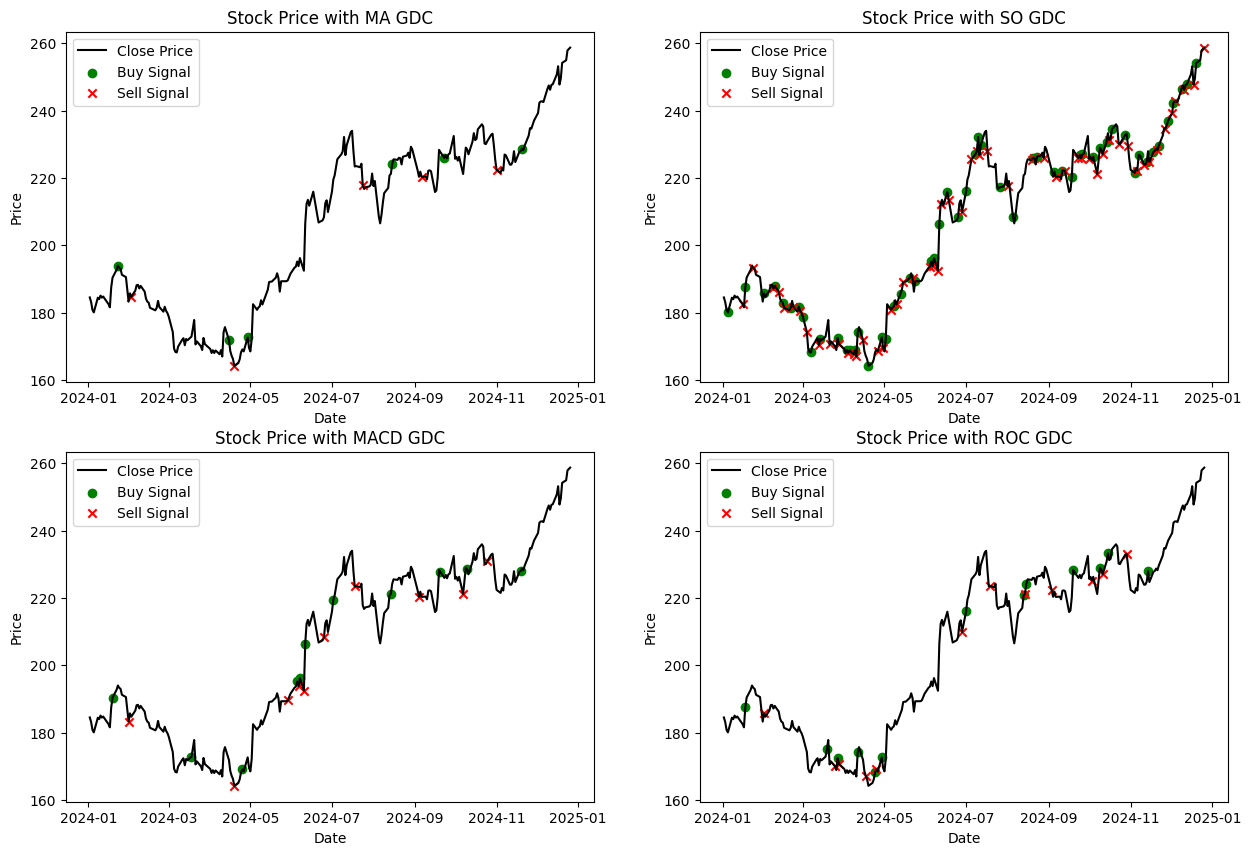

In [27]:
#최적화 안 된 매매신호 시각화
df_not_fit_sig = df_not_fit[(df_not_fit['Date'] >= '2024-01-01') & (df_not_fit['Date'] <= '2025-01-01')]

df_not_fit_sig.set_index('Date', inplace=True)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# MA_GDC
axs[0, 0].plot(df_not_fit_sig.index, df_not_fit_sig['Close'], label='Close Price', color='black')
buy_ma_signals = df_not_fit_sig[df_not_fit_sig['MA_GDC'] == 1]
sell_ma_signals = df_not_fit_sig[df_not_fit_sig['MA_GDC'] == -1]
axs[0, 0].scatter(buy_ma_signals.index, buy_ma_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[0, 0].scatter(sell_ma_signals.index, sell_ma_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[0, 0].set_title('Stock Price with MA GDC')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Price')
axs[0, 0].legend()

# SO_GDC
axs[0, 1].plot(df_not_fit_sig.index, df_not_fit_sig['Close'], label='Close Price', color='black')
buy_so_signals = df_not_fit_sig[df_not_fit_sig['SO_GDC'] == 1]
sell_so_signals = df_not_fit_sig[df_not_fit_sig['SO_GDC'] == -1]
axs[0, 1].scatter(buy_so_signals.index, buy_so_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[0, 1].scatter(sell_so_signals.index, sell_so_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[0, 1].set_title('Stock Price with SO GDC')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Price')
axs[0, 1].legend()

# MACD_GDC
axs[1, 0].plot(df_not_fit_sig.index, df_not_fit_sig['Close'], label='Close Price', color='black')
buy_macd_signals = df_not_fit_sig[df_not_fit_sig['MACD_GDC'] == 1]
sell_macd_signals = df_not_fit_sig[df_not_fit_sig['MACD_GDC'] == -1]
axs[1, 0].scatter(buy_macd_signals.index, buy_macd_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[1, 0].scatter(sell_macd_signals.index, sell_macd_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[1, 0].set_title('Stock Price with MACD GDC')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Price')
axs[1, 0].legend()

# ROC_GDC
axs[1, 1].plot(df_not_fit_sig.index, df_not_fit_sig['Close'], label='Close Price', color='black')
buy_ROC_signals = df_not_fit_sig[df_not_fit_sig['ROC_GDC'] == 1]
sell_ROC_signals = df_not_fit_sig[df_not_fit_sig['ROC_GDC'] == -1]
axs[1, 1].scatter(buy_ROC_signals.index, buy_ROC_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[1, 1].scatter(sell_ROC_signals.index, sell_ROC_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[1, 1].set_title('Stock Price with ROC GDC')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Price')
axs[1, 1].legend()

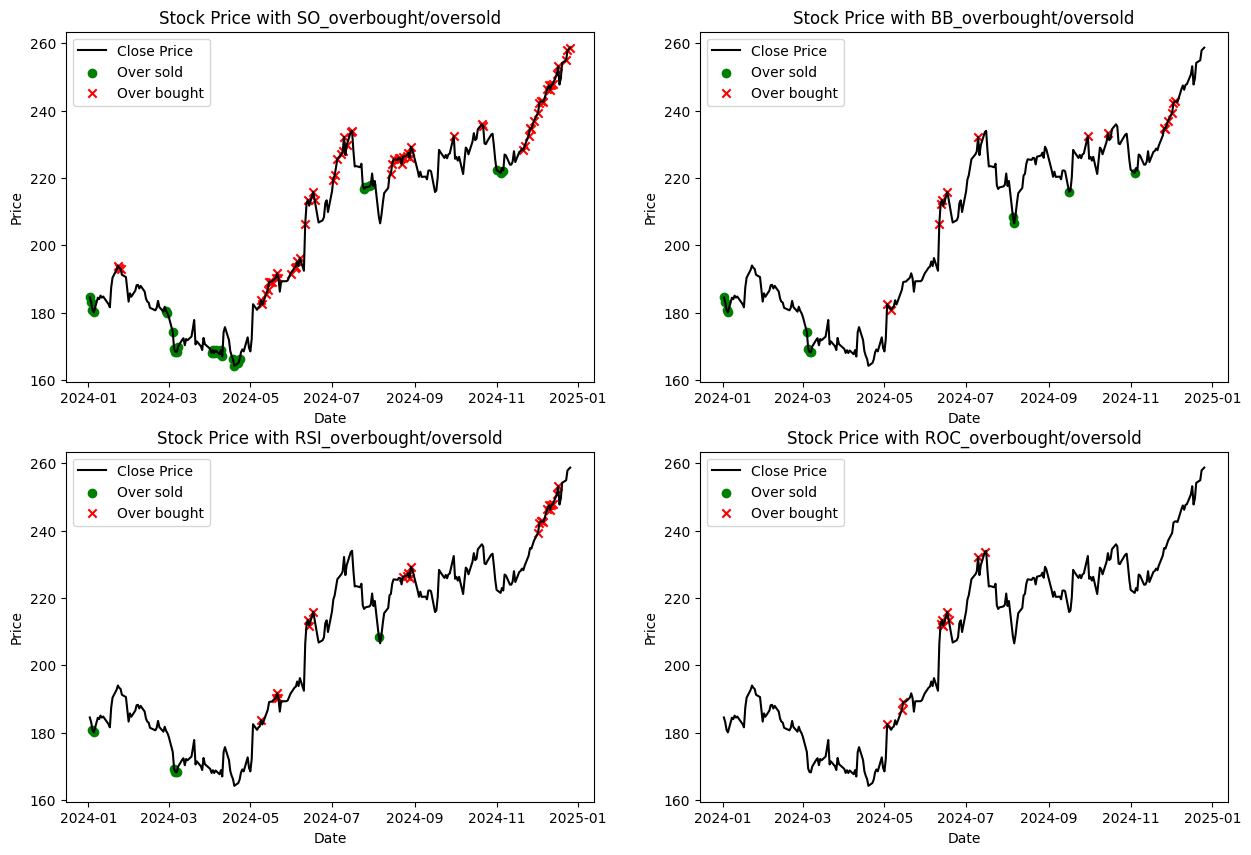

In [28]:
# 최적화 안 된 것 과매수 과매도 시각화

df_not_fit_sig = df_not_fit[(df_not_fit['Date'] >= '2024-01-01') & (df_not_fit['Date'] <= '2025-01-01')]
df_not_fit_sig.set_index('Date', inplace=True)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# SO_overbought/oversold
axs[0, 0].plot(df_not_fit_sig.index, df_not_fit_sig['Close'], label='Close Price', color='black')
so_oversold = df_not_fit_sig[df_not_fit_sig['SO_momentum'] == 1]   # 과매도
so_overbought = df_not_fit_sig[df_not_fit_sig['SO_momentum'] == -1] # 과매수
axs[0, 0].scatter(so_oversold.index, so_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[0, 0].scatter(so_overbought.index, so_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[0, 0].set_title('Stock Price with SO_overbought/oversold')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Price')
axs[0, 0].legend()

# Bollinger Bands
axs[0, 1].plot(df_not_fit_sig.index, df_not_fit_sig['Close'], label='Close Price', color='black')
bb_oversold = df_not_fit_sig[df_not_fit_sig['BB_momentum'] == 1]   # 과매도
bb_overbought = df_not_fit_sig[df_not_fit_sig['BB_momentum'] == -1] # 과매수
axs[0, 1].scatter(bb_oversold.index, bb_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[0, 1].scatter(bb_overbought.index, bb_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[0, 1].set_title('Stock Price with BB_overbought/oversold')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Price')
axs[0, 1].legend()

# RSI_overbought/oversold
axs[1, 0].plot(df_not_fit_sig.index, df_not_fit_sig['Close'], label='Close Price', color='black')
rsi_oversold = df_not_fit_sig[df_not_fit_sig['RSI_momentum'] == 1]   # 과매도
rsi_overbought = df_not_fit_sig[df_not_fit_sig['RSI_momentum'] == -1] # 과매수
axs[1, 0].scatter(rsi_oversold.index, rsi_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[1, 0].scatter(rsi_overbought.index, rsi_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[1, 0].set_title('Stock Price with RSI_overbought/oversold')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Price')
axs[1, 0].legend()

# ROC_overbought/oversold
axs[1, 1].plot(df_not_fit_sig.index, df_not_fit_sig['Close'], label='Close Price', color='black')
roc_oversold = df_not_fit_sig[df_not_fit_sig['ROC_momentum'] == 1]   # 과매도
roc_overbought = df_not_fit_sig[df_not_fit_sig['ROC_momentum'] == -1] # 과매수
axs[1, 1].scatter(roc_oversold.index, roc_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[1, 1].scatter(roc_overbought.index, roc_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[1, 1].set_title('Stock Price with ROC_overbought/oversold')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Price')
axs[1, 1].legend()


In [50]:
df_fit=df_price.copy()
create_rsi_momentum(df_fit, best_gene[0])
create_roc_GDC(df_fit, best_gene[1])
create_roc_momentum(df_fit, best_gene[2])
create_MA_GDC(df_fit, best_gene[3], best_gene[4])
create_MACD_GDC(df_fit, best_gene[5], best_gene[6], best_gene[7])
create_SO_GDC(df_fit, best_gene[8])
create_SO_momentum(df_fit, best_gene[9])
create_BB_momentum(df_fit, best_gene[10])

df_fit.dropna(inplace=True)

In [73]:
df_fit.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,target_return_3d,target,...,Low_w,High_w,%K,%D,SO_GDC,SO_momentum,MA_for_BB,BB_upper,BB_lower,BB_momentum
39,2010-03-02,6.317548,6.344632,6.251643,6.285047,566546400,0.0,0,4.836011,1,...,5.925128,6.344632,85.796297,92.094691,-1,-1,6.022423,6.316609,5.728238,0
40,2010-03-03,6.287756,6.315743,6.257662,6.299492,372052800,0.0,0,4.657727,1,...,5.925128,6.344632,89.239610,90.445888,0,-1,6.029669,6.341680,5.717658,0
41,2010-03-04,6.297989,6.347342,6.278427,6.341022,366041200,0.0,0,5.842156,1,...,6.078907,6.347342,97.645689,90.893866,1,-1,6.035190,6.364172,5.706208,0
42,2010-03-05,6.468317,6.611563,6.458988,6.588993,899620400,0.0,0,2.690135,1,...,6.182729,6.611563,94.736822,93.874041,0,-1,6.048003,6.433783,5.662222,-1
43,2010-03-08,6.620892,6.623299,6.567927,6.592905,429889600,0.0,0,2.930439,1,...,6.251643,6.623299,91.822007,94.734840,-1,-1,6.070909,6.511068,5.630749,-1


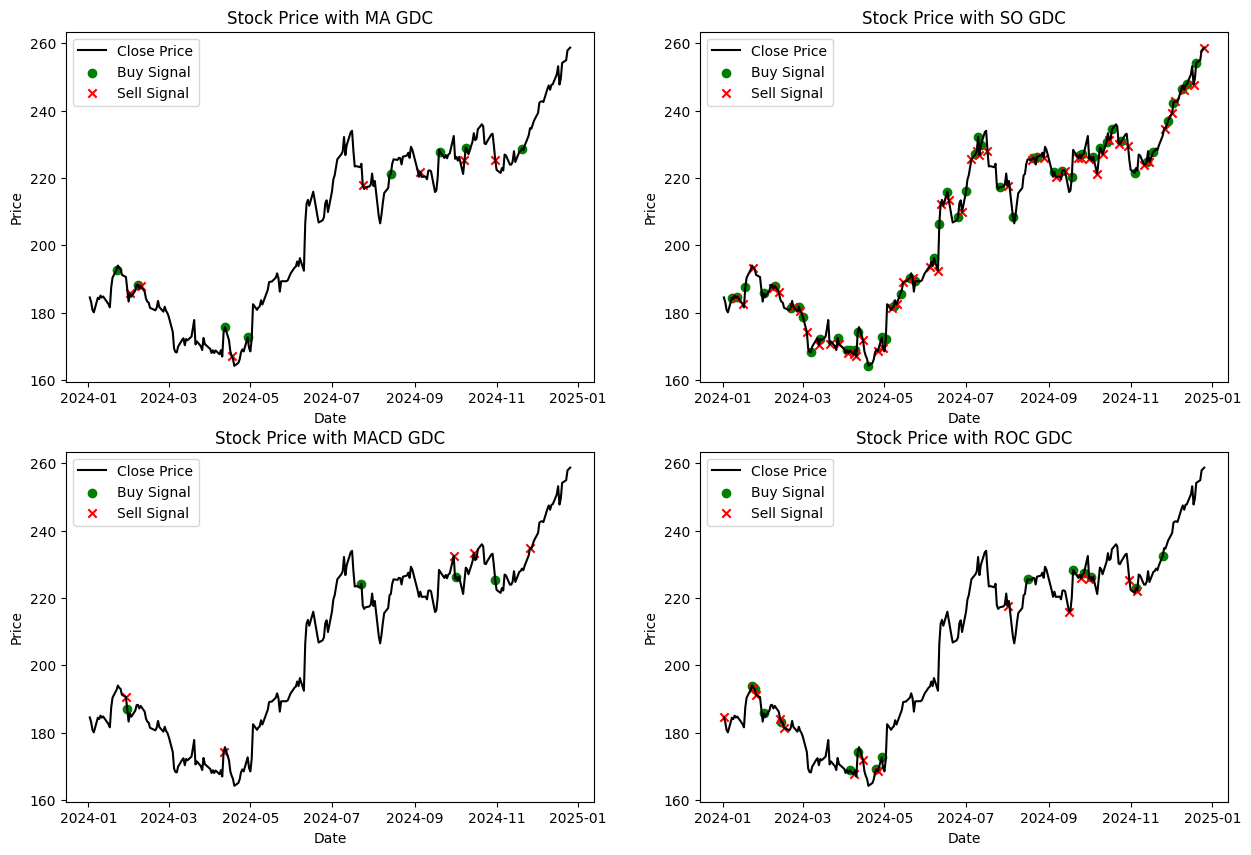

In [52]:
#최적화된 매매신호 시각화
df_fit_sig = df_fit[(df_fit['Date'] >= '2024-01-01') & (df_fit['Date'] <= '2025-01-01')]

df_fit_sig.set_index('Date', inplace=True)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# MA_GDC
axs[0, 0].plot(df_fit_sig.index, df_fit_sig['Close'], label='Close Price', color='black')
buy_ma_signals = df_fit_sig[df_fit_sig['MA_GDC'] == 1]
sell_ma_signals = df_fit_sig[df_fit_sig['MA_GDC'] == -1]
axs[0, 0].scatter(buy_ma_signals.index, buy_ma_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[0, 0].scatter(sell_ma_signals.index, sell_ma_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[0, 0].set_title('Stock Price with MA GDC')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Price')
axs[0, 0].legend()

# SO_GDC
axs[0, 1].plot(df_fit_sig.index, df_fit_sig['Close'], label='Close Price', color='black')
buy_so_signals = df_fit_sig[df_fit_sig['SO_GDC'] == 1]
sell_so_signals = df_fit_sig[df_fit_sig['SO_GDC'] == -1]
axs[0, 1].scatter(buy_so_signals.index, buy_so_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[0, 1].scatter(sell_so_signals.index, sell_so_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[0, 1].set_title('Stock Price with SO GDC')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Price')
axs[0, 1].legend()

# MACD_GDC
axs[1, 0].plot(df_fit_sig.index, df_fit_sig['Close'], label='Close Price', color='black')
buy_macd_signals = df_fit_sig[df_fit_sig['MACD_GDC'] == 1]
sell_macd_signals = df_fit_sig[df_fit_sig['MACD_GDC'] == -1]
axs[1, 0].scatter(buy_macd_signals.index, buy_macd_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[1, 0].scatter(sell_macd_signals.index, sell_macd_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[1, 0].set_title('Stock Price with MACD GDC')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Price')
axs[1, 0].legend()

# ROC_GDC
axs[1, 1].plot(df_fit_sig.index, df_fit_sig['Close'], label='Close Price', color='black')
buy_ROC_signals = df_fit_sig[df_fit_sig['ROC_GDC'] == 1]
sell_ROC_signals = df_fit_sig[df_fit_sig['ROC_GDC'] == -1]
axs[1, 1].scatter(buy_ROC_signals.index, buy_ROC_signals['Close'], marker='o', color='g', label='Buy Signal', alpha=1)
axs[1, 1].scatter(sell_ROC_signals.index, sell_ROC_signals['Close'], marker='x', color='r', label='Sell Signal', alpha=1)
axs[1, 1].set_title('Stock Price with ROC GDC')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Price')
axs[1, 1].legend()

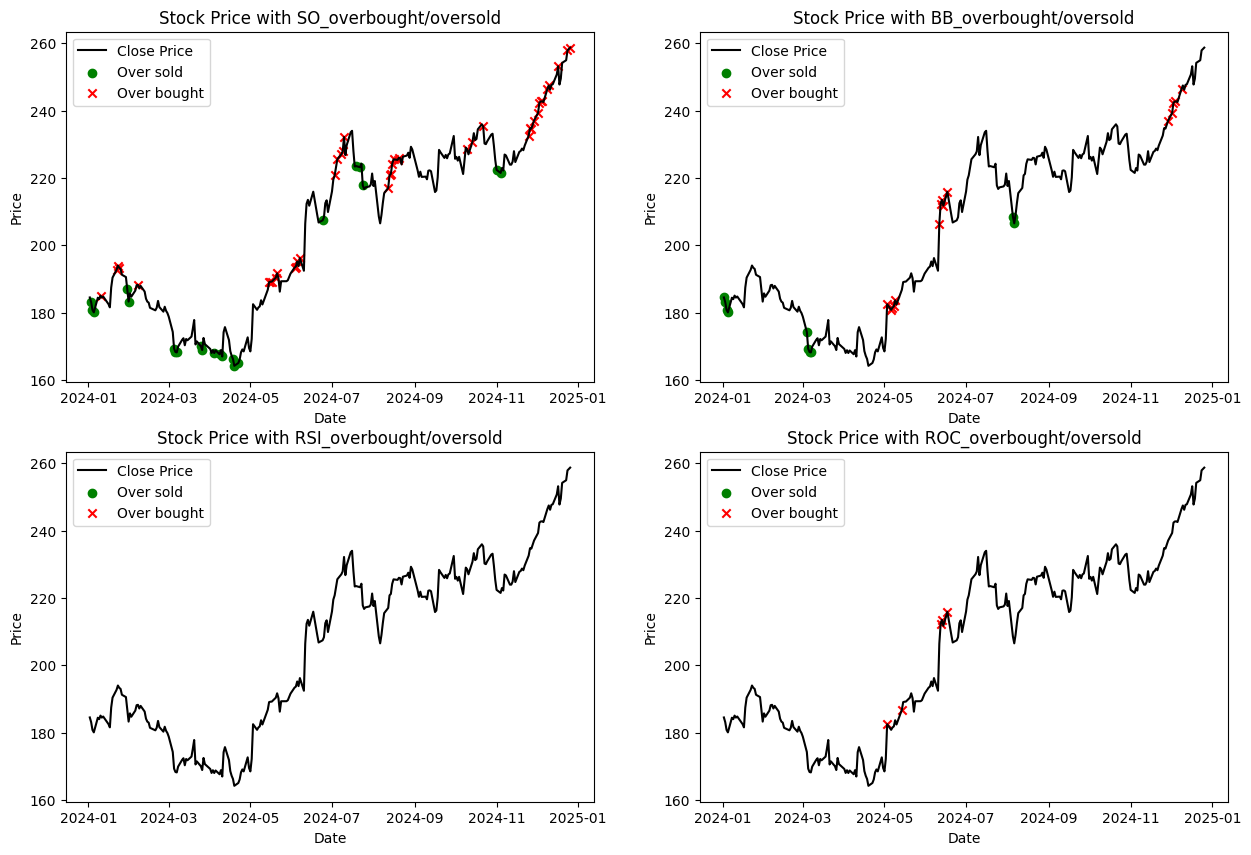

In [53]:
#최적화 된 과매수 과매도 시각화
df_fit_sig = df_fit[(df_fit['Date'] >= '2024-01-01') & (df_fit['Date'] <= '2025-01-01')]
df_fit_sig.set_index('Date', inplace=True)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# SO_overbought/oversold
axs[0, 0].plot(df_fit_sig.index, df_fit_sig['Close'], label='Close Price', color='black')
so_oversold = df_fit_sig[df_fit_sig['SO_momentum'] == 1]   # 과매도
so_overbought = df_fit_sig[df_fit_sig['SO_momentum'] == -1] # 과매수
axs[0, 0].scatter(so_oversold.index, so_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[0, 0].scatter(so_overbought.index, so_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[0, 0].set_title('Stock Price with SO_overbought/oversold')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Price')
axs[0, 0].legend()

# Bollinger Bands
axs[0, 1].plot(df_fit_sig.index, df_fit_sig['Close'], label='Close Price', color='black')
bb_oversold = df_fit_sig[df_fit_sig['BB_momentum'] == 1]   # 과매도
bb_overbought = df_fit_sig[df_fit_sig['BB_momentum'] == -1] # 과매수
axs[0, 1].scatter(bb_oversold.index, bb_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[0, 1].scatter(bb_overbought.index, bb_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[0, 1].set_title('Stock Price with BB_overbought/oversold')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Price')
axs[0, 1].legend()

# RSI_overbought/oversold
axs[1, 0].plot(df_fit_sig.index, df_fit_sig['Close'], label='Close Price', color='black')
rsi_oversold = df_fit_sig[df_fit_sig['RSI_momentum'] == 1]   # 과매도
rsi_overbought = df_fit_sig[df_fit_sig['RSI_momentum'] == -1] # 과매수
axs[1, 0].scatter(rsi_oversold.index, rsi_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[1, 0].scatter(rsi_overbought.index, rsi_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[1, 0].set_title('Stock Price with RSI_overbought/oversold')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Price')
axs[1, 0].legend()

# ROC_overbought/oversold
axs[1, 1].plot(df_fit_sig.index, df_fit_sig['Close'], label='Close Price', color='black')
roc_oversold = df_fit_sig[df_fit_sig['ROC_momentum'] == 1]   # 과매도
roc_overbought = df_fit_sig[df_fit_sig['ROC_momentum'] == -1] # 과매수
axs[1, 1].scatter(roc_oversold.index, roc_oversold['Close'], marker='o', color='g', label='Over sold', alpha=1)
axs[1, 1].scatter(roc_overbought.index, roc_overbought['Close'], marker='x', color='r', label='Over bought', alpha=1)
axs[1, 1].set_title('Stock Price with ROC_overbought/oversold')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Price')
axs[1, 1].legend()


###최적화 된 값이 누적 수익률이 높고 최대 낙폭이 더 작음이 확인됨###

In [33]:
#최적화 안한 것
total_cum_ret=0
total_MDD=0
for ta in ['RSI_momentum', 'ROC_GDC', 'ROC_momentum', 'MA_GDC', 'MACD_GDC', 'SO_GDC', 'SO_momentum', 'BB_momentum']:
    cum_ret, MDD = cumulative_return_and_MDD(df_not_fit, ta)
    print(f"{ta}: (누적수익률:{cum_ret}, MDD:{MDD})")
    total_cum_ret+=cum_ret
    total_MDD+=MDD
print(f"총 누적 수익률: {total_cum_ret}, 총 최대 낙폭: {total_MDD}")

RSI_momentum: (누적수익률:1e-05, MDD:-0.6096660056303586)
ROC_GDC: (누적수익률:1.3603719366071274, MDD:-0.40675314104112603)
ROC_momentum: (누적수익률:3.8876154981419013, MDD:-0.2781850940010115)
MA_GDC: (누적수익률:1.1743634199923547, MDD:-0.41391064121809873)
MACD_GDC: (누적수익률:1e-05, MDD:-0.3694258414027517)
SO_GDC: (누적수익률:1e-05, MDD:-0.6949538455796865)
SO_momentum: (누적수익률:1e-05, MDD:-0.98465108276558)
BB_momentum: (누적수익률:1.541897041068282, MDD:-0.4392117403100073)
총 누적 수익률: 7.9642878958096635, 총 최대 낙폭: -4.196757391948621


In [72]:
#최적화 한 것
total_cum_ret=0
total_MDD=0
for ta in ['RSI_momentum', 'ROC_GDC', 'ROC_momentum', 'MA_GDC', 'MACD_GDC', 'SO_GDC', 'SO_momentum', 'BB_momentum']:
    cum_ret, MDD = cumulative_return_and_MDD(df_fit, ta)
    print(f"{ta}: (누적수익률:{cum_ret}, MDD:{MDD})")
    total_cum_ret+=cum_ret
    total_MDD+=MDD
print(f"총 누적 수익률: {total_cum_ret}, 총 최대 낙폭: {total_MDD}")

RSI_momentum: (누적수익률:1e-05, MDD:-0.33804312550764537)
ROC_GDC: (누적수익률:1.8661293521044748, MDD:-0.23251154212381997)
ROC_momentum: (누적수익률:4.19585385909218, MDD:-0.2435442009017169)
MA_GDC: (누적수익률:3.007280978749875, MDD:-0.12579429560237923)
MACD_GDC: (누적수익률:1.7473810457712007, MDD:-0.15167426242650583)
SO_GDC: (누적수익률:1e-05, MDD:-0.6031807650385721)
SO_momentum: (누적수익률:1e-05, MDD:-0.8623411077550878)
BB_momentum: (누적수익률:2.244402354532352, MDD:-0.2762277001579276)
총 누적 수익률: 13.061077590250083, 총 최대 낙폭: -2.833316999513655


##모델의 결과를 통해 최적화의 차이를 비교##

In [55]:
# PreProcessing
# 1. 필요한 컬럼만 추출
cols_needed = ["Earnings Date", "Reported EPS", "EPS Estimate", "Surprise(%)"]
df_earnings = df_earnings[cols_needed].copy()

# 2. 실적 데이터 타입 및 인덱스 설정 (중복 제거 포함)
df_earnings["Earnings Date"] = pd.to_datetime(df_earnings["Earnings Date"], errors='coerce')
df_earnings = df_earnings.dropna(subset=["Earnings Date"])  # 날짜형 변환 실패 제거
df_earnings = df_earnings.drop_duplicates(subset="Earnings Date")
df_earnings = df_earnings.sort_values(by="Earnings Date").reset_index(drop=True)

In [56]:
# 3. 실적 데이터 Up Sampling (일 단위로 확장, forward fill)
df_earnings.set_index("Earnings Date", inplace=True)
df_earnings = df_earnings.resample('D').ffill()

In [57]:
df_earnings.shape

(5576, 3)

In [58]:
df_earnings.head(5)

,Reported EPS,EPS Estimate,Surprise(%)
Earnings Date,,,
2010-01-25,0.13,0.07,76.0
2010-01-26,0.13,0.07,76.0
2010-01-27,0.13,0.07,76.0
2010-01-28,0.13,0.07,76.0
2010-01-29,0.13,0.07,76.0


###최적화 안 된 데이터로 모델 학습###

In [59]:
#실적 데이터와 통합
df_not_fit_for_model=df_not_fit.copy()
df_earnings_for_model = df_earnings.copy()
df_earnings_for_model.reset_index(inplace=True)

df_earnings_for_model.rename(columns={"Earnings Date": "Date"}, inplace=True)
df_not_fit_merge=pd.merge(df_not_fit_for_model, df_earnings_for_model, on="Date", how="left")
df_not_fit_merge.set_index("Date", inplace=True)

df_not_fit_merge.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,target_return_3d,target,RSI_value,...,%D,SO_GDC,SO_momentum,MA_for_BB,BB_upper,BB_lower,BB_momentum,Reported EPS,EPS Estimate,Surprise(%)
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-01,5.789106,5.898346,5.756906,5.860127,749876400,0.0,0,-1.376280,-1,38.180171,...,12.148237,1,1,6.231361,6.624758,5.837964,0,0.13,0.07,76.0
2010-02-02,5.895639,5.907977,5.819502,5.894134,698342400,0.0,0,-0.204298,0,40.705356,...,15.678656,0,0,6.204051,6.611935,5.796167,0,0.13,0.07,76.0
2010-02-03,5.873367,6.024738,5.850797,5.995547,615328000,0.0,0,-2.564872,-1,41.111444,...,25.125283,0,0,6.181255,6.581813,5.780697,0,0.13,0.07,76.0
2010-02-04,5.920312,5.969666,5.765030,5.779475,757652000,0.0,0,2.155673,1,37.621084,...,21.594280,-1,0,6.152786,6.583025,5.722547,0,0.13,0.07,76.0
2010-02-05,5.796928,5.898343,5.743361,5.882092,850306800,0.0,0,-0.173919,0,42.533063,...,21.067090,0,0,6.130036,6.567300,5.692771,0,0.13,0.07,76.0


In [60]:
df_not_fit_merge.shape

(3752, 35)

In [95]:
# Data Splitting
# 1. 학습 / 검증 / 테스트 분할 기준 설정
train_end = "2022-12-31"
val_end = "2023-12-31"

# 2. Feature 선택
#누적 수익률이 높고 최대 낙폭이 낮은 매매신호를 선택
#(최적화 되지 않은 MACD_GDC는 낮은 누적 수익률을 가지지만 최적화 된 MACD는 꽤 괜찮은 성능을 보이므로 비교를 위한 변인 통제로 feature에 추가)
features = ["Close", "Volume", "Surprise(%)", "ROC_GDC", "ROC_momentum", "MA_GDC", "MACD_GDC", "BB_momentum"]

df_not_fit_filtered = df_not_fit_merge.dropna(subset=features + ["target_return_3d"])  # 결측치 제거
X_not_fit = df_not_fit_filtered[features]

# 클래스 매핑 정의
label_mapping = {-1: 0, 0: 1, 1: 2}
# 매핑 적용
y_not_fit = df_not_fit_filtered["target"].map(label_mapping)


# 3. 시계열 분할
X_train_not_fit = X_not_fit[X_not_fit.index <= train_end]
X_val_not_fit = X_not_fit[(X_not_fit.index > train_end) & (X_not_fit.index <= val_end)]
X_test_not_fit = X_not_fit[X_not_fit.index > val_end]

y_train_not_fit = y_not_fit[X_not_fit.index <= train_end]
y_val_not_fit = y_not_fit[(X_not_fit.index > train_end) & (X.index <= val_end)]
y_test_not_fit = y_not_fit[X_not_fit.index > val_end]

# 4. 결과 확인
print("X_train:", X_train_not_fit.shape)
print("X_val:", X_val_not_fit.shape)
print("X_test:", X_test_not_fit.shape)

X_train: (3253, 8)
X_val: (250, 8)
X_test: (249, 8)


####베이스라인 모델 XG_Boost####

In [96]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 다중 클래스 분류를 위한 XGBoost 설정
model = XGBClassifier(
    objective="multi:softmax",
    num_class=3,   # -1, 0, 1 → 총 3개 클래스
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

# 학습
model.fit(X_train_not_fit, y_train_not_fit)

# 검증
y_pred_not_fit = model.predict(X_val_not_fit)

# 평가
print("Classification Report:\n", classification_report(y_val_not_fit, y_pred_not_fit))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:29:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.77      0.39        60
           1       0.31      0.13      0.19        82
           2       0.51      0.19      0.27       108

    accuracy                           0.31       250
   macro avg       0.36      0.36      0.28       250
weighted avg       0.38      0.31      0.27       250



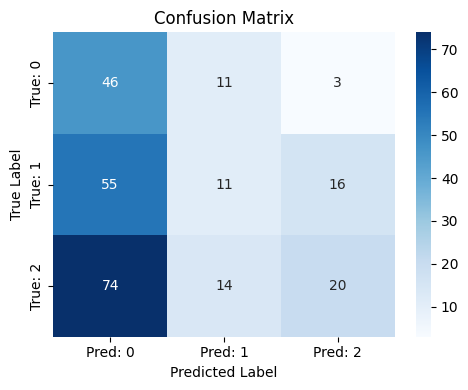

In [97]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val_not_fit, y_pred_not_fit)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1', 'Pred: 2'], yticklabels=['True: 0', 'True: 1', 'True: 2'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.44      0.34        64
           1       0.37      0.62      0.46        86
           2       0.00      0.00      0.00        99

    accuracy                           0.33       249
   macro avg       0.21      0.35      0.27       249
weighted avg       0.20      0.33      0.25       249



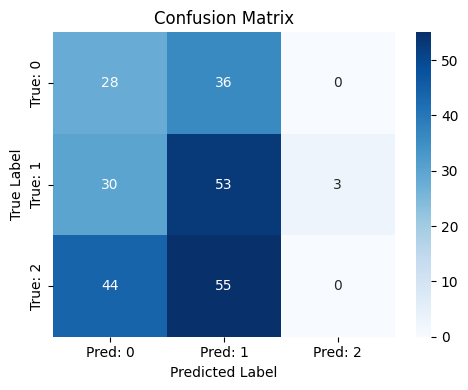

In [98]:
#테스트 데이터
y_pred_not_fit_test = model.predict(X_test_not_fit)
print("Classification Report:\n", classification_report(y_test_not_fit, y_pred_not_fit_test))
cm = confusion_matrix(y_test_not_fit, y_pred_not_fit_test)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1', 'Pred: 2'], yticklabels=['True: 0', 'True: 1', 'True: 2'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

####최적화 된 데이터로 모델 학습####

In [74]:
#실적 데이터와 통합
df_fit_for_model=df_fit.copy()
df_earnings_for_model = df_earnings.copy()
df_earnings_for_model.reset_index(inplace=True)

df_earnings_for_model.rename(columns={"Earnings Date": "Date"}, inplace=True)
df_fit_merge=pd.merge(df_fit_for_model, df_earnings_for_model, on="Date", how="left")
df_fit_merge.set_index("Date", inplace=True)

df_fit_merge.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,target_return_3d,target,RSI_value,...,%D,SO_GDC,SO_momentum,MA_for_BB,BB_upper,BB_lower,BB_momentum,Reported EPS,EPS Estimate,Surprise(%)
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-02,6.317548,6.344632,6.251643,6.285047,566546400,0.0,0,4.836011,1,47.841347,...,92.094691,-1,-1,6.022423,6.316609,5.728238,0,0.13,0.07,76.0
2010-03-03,6.287756,6.315743,6.257662,6.299492,372052800,0.0,0,4.657727,1,48.049980,...,90.445888,0,-1,6.029669,6.341680,5.717658,0,0.13,0.07,76.0
2010-03-04,6.297989,6.347342,6.278427,6.341022,366041200,0.0,0,5.842156,1,48.483605,...,90.893866,1,-1,6.035190,6.364172,5.706208,0,0.13,0.07,76.0
2010-03-05,6.468317,6.611563,6.458988,6.588993,899620400,0.0,0,2.690135,1,53.170662,...,93.874041,0,-1,6.048003,6.433783,5.662222,-1,0.13,0.07,76.0
2010-03-08,6.620892,6.623299,6.567927,6.592905,429889600,0.0,0,2.930439,1,53.384302,...,94.734840,-1,-1,6.070909,6.511068,5.630749,-1,0.13,0.07,76.0


In [77]:
df_fit_merge.shape

(3732, 35)

In [99]:
# Data Splitting
# 1. 학습 / 검증 / 테스트 분할 기준 설정
train_end = "2022-12-31"
val_end = "2023-12-31"

# 2. Feature 선택
features = ["Close", "Volume", "Surprise(%)", "ROC_GDC", "ROC_momentum", "MA_GDC", "MACD_GDC", "BB_momentum"]

df_fit_filtered = df_fit_merge.dropna(subset=features + ["target_return_3d"])  # 결측치 제거
X_fit = df_fit_filtered[features]

# 클래스 매핑 정의
label_mapping = {-1: 0, 0: 1, 1: 2}
# 매핑 적용
y_fit = df_fit_filtered["target"].map(label_mapping)


# 3. 시계열 분할
X_train_fit = X_fit[X_fit.index <= train_end]
X_val_fit = X_fit[(X_fit.index > train_end) & (X_fit.index <= val_end)]
X_test_fit = X_fit[X_fit.index > val_end]

y_train_fit = y_fit[X_fit.index <= train_end]
y_val_fit = y_fit[(X_fit.index > train_end) & (X_fit.index <= val_end)]
y_test_fit = y_fit[X_fit.index > val_end]

# 4. 결과 확인
print("X_train:", X_train_fit.shape)
print("X_val:", X_val_fit.shape)
print("X_test:", X_test_fit.shape)

X_train: (3233, 8)
X_val: (250, 8)
X_test: (249, 8)


In [100]:
# 다중 클래스 분류를 위한 XGBoost 설정
model = XGBClassifier(
    objective="multi:softmax",
    num_class=3,   # -1, 0, 1 → 총 3개 클래스
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

# 학습
model.fit(X_train_fit, y_train_fit)

# 검증
y_pred_fit = model.predict(X_val_fit)

# 평가 (상승장을 예측할 수 있게 됨, 최적화 되지 않은 것은 f1 score가 0)
print("Classification Report:\n", classification_report(y_val_fit, y_pred_fit))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:31:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.82      0.43        60
           1       0.27      0.12      0.17        82
           2       0.52      0.22      0.31       108

    accuracy                           0.33       250
   macro avg       0.36      0.39      0.30       250
weighted avg       0.38      0.33      0.29       250



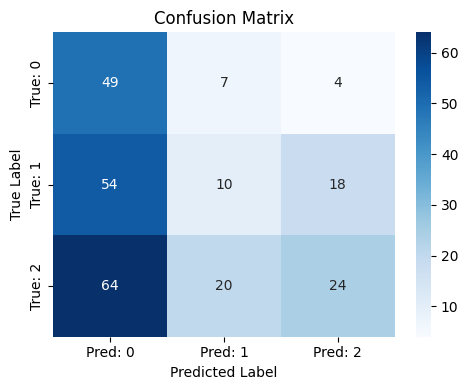

In [101]:
cm = confusion_matrix(y_val_fit, y_pred_fit)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1', 'Pred: 2'], yticklabels=['True: 0', 'True: 1', 'True: 2'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.44      0.34        64
           1       0.38      0.65      0.48        86
           2       0.00      0.00      0.00        99

    accuracy                           0.34       249
   macro avg       0.22      0.36      0.27       249
weighted avg       0.20      0.34      0.25       249



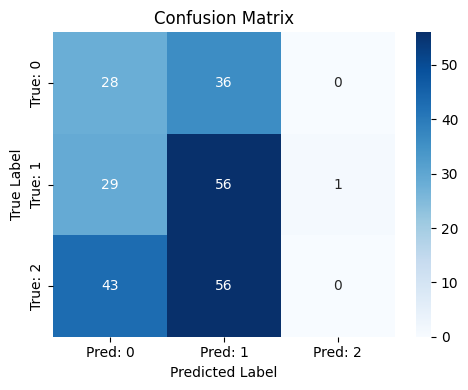

In [102]:
#테스트 데이터
y_pred_fit_test = model.predict(X_test_fit)
print("Classification Report:\n", classification_report(y_test_fit, y_pred_fit_test))
cm = confusion_matrix(y_test_fit, y_pred_fit_test)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1', 'Pred: 2'], yticklabels=['True: 0', 'True: 1', 'True: 2'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

모델 없이 기술적 지표를 이용하여 최적화 한 결과 테스트 데이터에서 최적화가 되었든 되지 않았든 상승장에 대한 예측이 전혀 되지 않았음, 정확도는 최적화 된 것이 1% 정도 미미하게 상승

In [105]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

#시퀀스 생성 함수
def create_sequences(X, y, window_size=10):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i + window_size])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

In [107]:
#학습 데이터 스케일링
scaler=StandardScaler()
cols_to_scale = ["Close", "Volume", "Surprise(%)"]
X_not_fit.loc[:, cols_to_scale] = scaler.fit_transform(X_not_fit[cols_to_scale].astype('float64'))
X_fit.loc[:, cols_to_scale] = scaler.fit_transform(X_fit[cols_to_scale].astype('float64'))

In [108]:
#최적화 안된 것
X_train_not_fit = X_not_fit[X_not_fit.index <= train_end]
X_val_not_fit = X_not_fit[(X_not_fit.index > train_end) & (X_not_fit.index <= val_end)]
X_test_not_fit = X_not_fit[X_not_fit.index > val_end]

y_train_not_fit = y_not_fit[X_not_fit.index <= train_end]
y_val_not_fit = y_not_fit[(X_not_fit.index > train_end) & (X_not_fit.index <= val_end)]
y_test_not_fit = y_not_fit[X_not_fit.index > val_end]

X_train_not_fit, y_train_not_fit = create_sequences(X_train_not_fit, y_train_not_fit.values)
X_val_not_fit, y_val_not_fit = create_sequences(X_val_not_fit, y_val_not_fit.values)
X_test_not_fit, y_test_not_fit = create_sequences(X_test_not_fit, y_test_not_fit.values)

In [115]:
lstm_model=Sequential()
lstm_model.add(Input(shape=(X_train_not_fit.shape[1], X_train_not_fit.shape[2])))
lstm_model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_not_fit, y_train_not_fit, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.3901 - loss: 1.0916
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3995 - loss: 1.0821
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3923 - loss: 1.0832
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.3949 - loss: 1.0800
Epoch 5/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.4207 - loss: 1.0753
Epoch 6/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4097 - loss: 1.0760
Epoch 7/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4135 - loss: 1.0708
Epoch 8/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4286 - loss: 1.0743
Epoch 9/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4251 - loss: 1.0618
Epoch 10/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.4177 - loss: 1.0719
Epoch 11/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4299 - loss: 1.0644
Epoch 12/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 

Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.45      0.33        60
           1       0.33      0.01      0.02        81
           2       0.41      0.56      0.47        99

    accuracy                           0.35       240
   macro avg       0.34      0.34      0.28       240
weighted avg       0.35      0.35      0.29       240



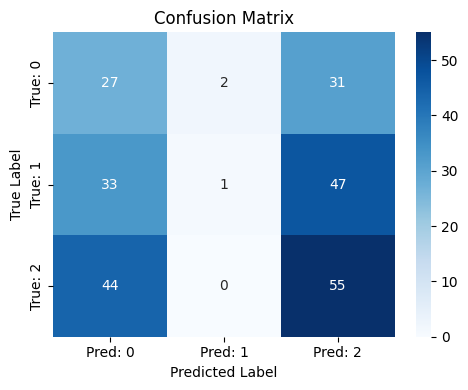

In [116]:
#검증 데이터
y_pred_not_fit = np.argmax(lstm_model.predict(X_val_not_fit, verbose=0), axis=1)
print("Classification Report:\n", classification_report(y_val_not_fit, y_pred_not_fit))
cm = confusion_matrix(y_val_not_fit, y_pred_not_fit)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1', 'Pred: 2'], yticklabels=['True: 0', 'True: 1', 'True: 2'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.85      0.42        61
           1       0.00      0.00      0.00        83
           2       0.42      0.23      0.30        95

    accuracy                           0.31       239
   macro avg       0.23      0.36      0.24       239
weighted avg       0.24      0.31      0.23       239



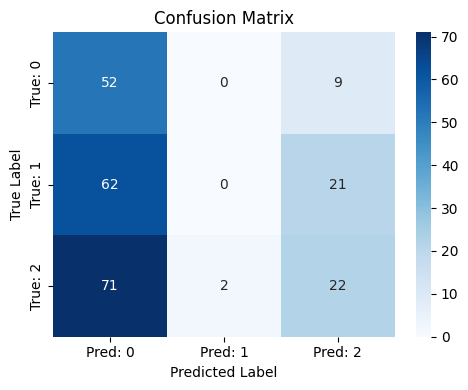

In [120]:
#테스트 데이터
y_pred_not_fit_test = np.argmax(lstm_model.predict(X_test_not_fit, verbose=0), axis=1)
print("Classification Report:\n", classification_report(y_test_not_fit, y_pred_not_fit_test))
cm = confusion_matrix(y_test_not_fit, y_pred_not_fit_test)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1', 'Pred: 2'], yticklabels=['True: 0', 'True: 1', 'True: 2'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [121]:
#최적화 된 데이터로 학습
X_train_fit = X_fit[X_fit.index <= train_end]
X_val_fit = X_fit[(X_fit.index > train_end) & (X_fit.index <= val_end)]
X_test_fit = X_fit[X_fit.index > val_end]

y_train_fit = y_fit[X_fit.index <= train_end]
y_val_fit = y_fit[(X_fit.index > train_end) & (X_fit.index <= val_end)]
y_test_fit = y_fit[X_fit.index > val_end]

X_train_fit, y_train_fit = create_sequences(X_train_fit, y_train_fit.values)
X_val_fit, y_val_fit = create_sequences(X_val_fit, y_val_fit.values)
X_test_fit, y_test_fit = create_sequences(X_test_fit, y_test_fit.values)

In [122]:
lstm_model=Sequential()
lstm_model.add(Input(shape=(X_train_fit.shape[1], X_train_fit.shape[2])))
lstm_model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_fit, y_train_fit, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.3807 - loss: 1.0953
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.4149 - loss: 1.0832
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.3871 - loss: 1.0848
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.3877 - loss: 1.0814
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.4105 - loss: 1.0810
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.4096 - loss: 1.0750
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4164 - loss: 1.0743
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4276 - loss: 1.0677
Epoch 9/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.4232 - loss: 1.0676
Epoch 10/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.4203 - loss: 1.0719
Epoch 11/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.4454 - loss: 1.0589
Epoch 12/30
101/101 ━━━━━━━━━━━━━━━━━━━━

Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.42      0.28        60
           1       1.00      0.01      0.02        81
           2       0.39      0.48      0.43        99

    accuracy                           0.31       240
   macro avg       0.54      0.30      0.25       240
weighted avg       0.55      0.31      0.26       240



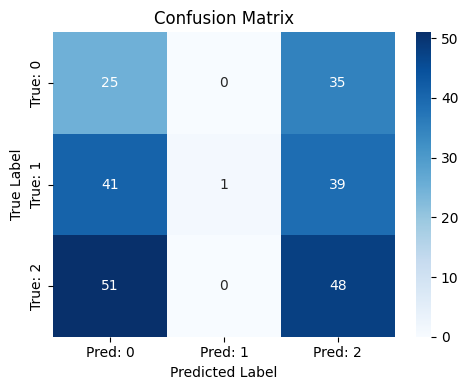

In [123]:
#검증 데이터
y_pred_fit = np.argmax(lstm_model.predict(X_val_fit, verbose=0), axis=1)
print("Classification Report:\n", classification_report(y_val_fit, y_pred_fit))
cm = confusion_matrix(y_val_fit, y_pred_fit)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1', 'Pred: 2'], yticklabels=['True: 0', 'True: 1', 'True: 2'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.66      0.35        61
           1       0.00      0.00      0.00        83
           2       0.39      0.29      0.34        95

    accuracy                           0.28       239
   macro avg       0.21      0.32      0.23       239
weighted avg       0.22      0.28      0.22       239



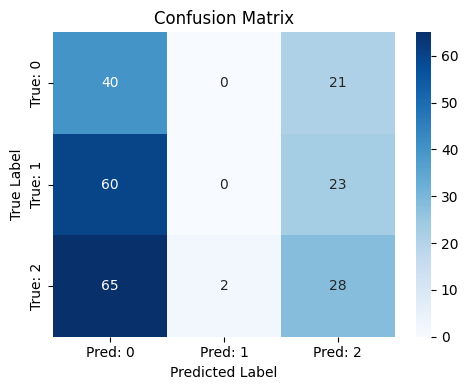

In [127]:
#테스트 데이터
y_pred_fit_test = np.argmax(lstm_model.predict(X_test_fit, verbose=0), axis=1)
print("Classification Report:\n", classification_report(y_test_fit, y_pred_fit_test))
cm = confusion_matrix(y_test_fit, y_pred_fit_test)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1', 'Pred: 2'], yticklabels=['True: 0', 'True: 1', 'True: 2'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

LSTM의 경우 최적화 한 데이터가 더 낮은 정확도를 가짐, LSTM의 경우 횡보되는 주식가격을 전혀 예측하지 못하고 있음